<a href="https://www.kaggle.com/code/akscent/review-classifer-transformers?scriptVersionId=148340251" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install pymorphy2
%load_ext autoreload
%autoreload 2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.5 MB/s eta 0:00:00


# Import Libraries

In [2]:
import os
import sys
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.insert(1, '/kaggle/input/ods-huawei/nlp_huawei_new2_task-master/nlp_huawei_new2_task-master/baseline_transformers')
from dataset import *
from model import *
from trainer import Trainer

torch.manual_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from typing import Dict

import torch
import json
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
from tqdm.notebook import tqdm

from model import ModelForClassification


class Trainer:
    def __init__(self, config: Dict, class_weights=None):
        self.config = config
        self.device = config['device']
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: AdamW(model.parameters(), config['lr'])
#         self.scheduler1 = ExponentialLR(opt_fn, gamma=0.9)
#         self.scheduler2 = MultiStepLR(opt_fn, milestones=[30,80], gamma=0.1)
        self.model = None
        self.history = None
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
            self.loss_fn = CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = CrossEntropyLoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)
        
    def save_history(self, path: str):
        history = {
            'train_loss': self.history['train_loss'],
            'val_loss': self.history['val_loss'],
            'val_acc': self.history['val_acc']
        }
        with open(path, 'w') as file:
            json.dump(history, file)
        
    def load_history(self, path: str):
        with open(path, 'r') as file:
            history = json.load(file)
        self.history = {
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_acc': history['val_acc']
        }

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])
            self.save_history('history.json')

        return self.model.eval()


    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
#             scheduler1.step()
#             scheduler2.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        print(acc)
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                predictions.extend(outputs.argmax(1).tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    def plot_history(self):
        import matplotlib.pyplot as plt
        
        if self.history is None:
            raise RuntimeError("History is not available. Train the model first.")

        train_loss = self.history['train_loss']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_acc']

        epochs = range(1, len(train_loss) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer

In [4]:
PATH = "/kaggle/input/ods-huawei/"
MAX_LEN = 50
BATCH_SIZE = 36

# Loading data

In [5]:
train_data = pd.read_csv(os.path.join(PATH, "train.csv"))
test_data = pd.read_csv(os.path.join(PATH, "test.csv"))

train_data.head()

rate                                               text
0     4  Очень понравилось. Были в начале марта  с соба...
1     5  В целом магазин устраивает.\nАссортимент позво...
2     5  Очень хорошо что открылась 5 ка, теперь не над...
3     3  Пятёрочка громко объявила о том как она заботи...
4     3  Тесно, вечная сутолока, между рядами трудно ра...

# Label encoding

In [6]:
le = LabelEncoder()

train_data.rate = le.fit_transform(train_data.rate)
train_data.head()

rate                                               text
0     3  Очень понравилось. Были в начале марта  с соба...
1     4  В целом магазин устраивает.\nАссортимент позво...
2     4  Очень хорошо что открылась 5 ка, теперь не над...
3     2  Пятёрочка громко объявила о том как она заботи...
4     2  Тесно, вечная сутолока, между рядами трудно ра...

# EDA

<Axes: ylabel='Frequency'>

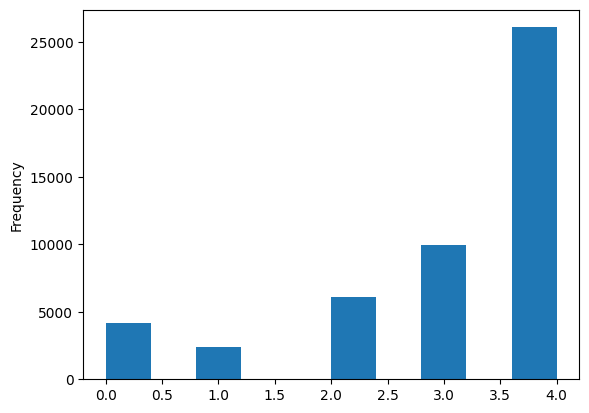

In [7]:
train_data['rate'].plot.hist(grid=False)

# Дисбаланс классов
# попробуем устранить его на этапе моделирования при помощи весо-зависимого лосса

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from string import punctuation

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


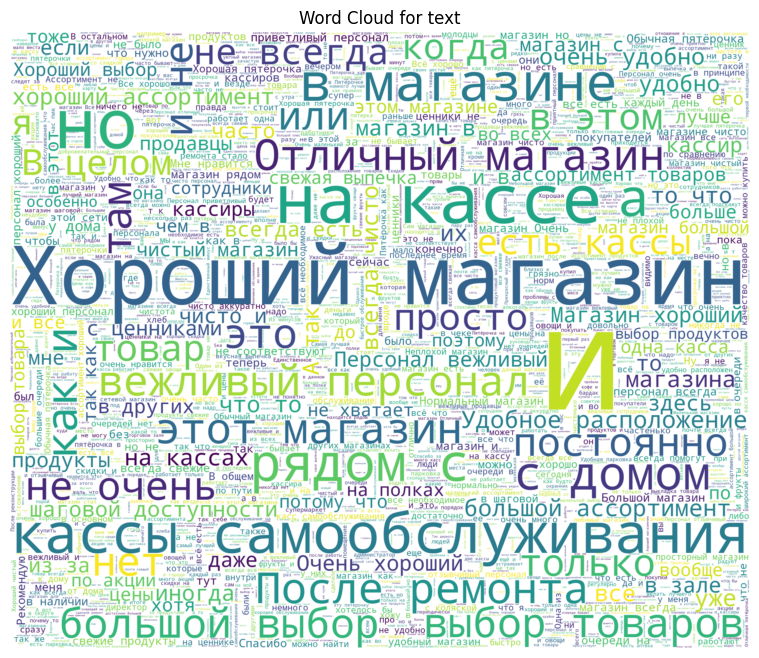

In [9]:
import matplotlib.pyplot as plt
def get_word_cloud(data, text_column, max_words=2000):
    text = ' '.join(data[text_column])
    word_cloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        width=3000,
        height=2500,
        max_words=max_words
    ).generate(text)
    return word_cloud

def display_word_cloud(data, text_column, max_words=2000):
    word_cloud = get_word_cloud(data, text_column, max_words)
    plt.figure(figsize=(10, 8))
    plt.title('Word Cloud for ' + text_column)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
display_word_cloud(train_data, text_column='text')

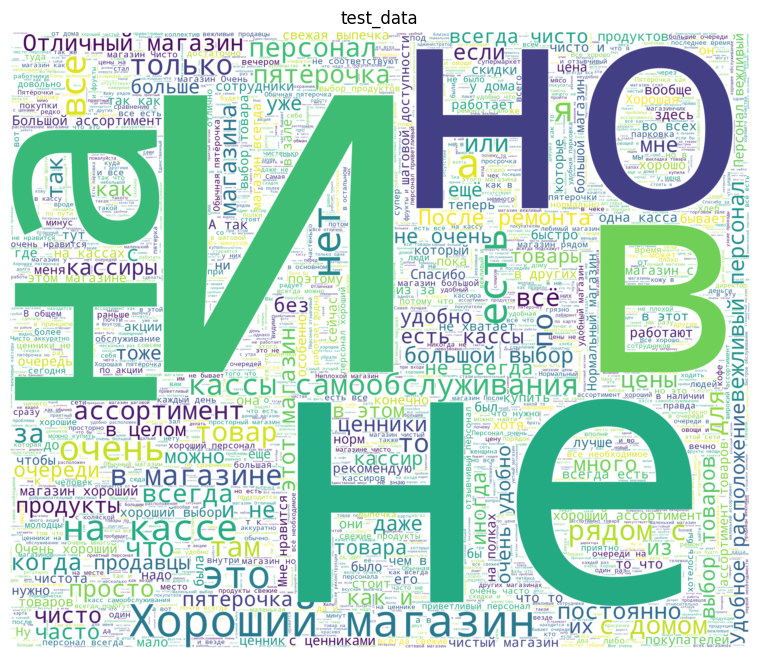

In [10]:
word_cloud = get_word_cloud(test_data, text_column='text')
plt.figure(figsize=(10, 8))
plt.title('test_data')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
# Если чистить, нужно почистить с возможностью сохранения приставок не и слов нет как маркеров отрицания
import re
from nltk.corpus import stopwords
import pymorphy2

TOKEN_RE = re.compile(r'[а-яё]+')
russian_stopwords = set(stopwords.words("russian"))
lemmatizer = pymorphy2.MorphAnalyzer()

def tokenize_text(text, min_length_token=2):
    text = text.lower()
    tokens = TOKEN_RE.findall(text)
    return [token for token in tokens if len(token) >= min_length_token]

def remove_stopwords(tokens):
    return [token for token in tokens if token not in russian_stopwords]

def lemmatize(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(text):
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens)
    return ' '.join(tokens)


In [12]:
from tqdm.notebook import tqdm
tqdm.pandas()
df_token = train_data.copy()
df_token['text'] = df_token['text'].progress_apply(text_cleaning)
df_token.head()

  0%|          | 0/48665 [00:00<?, ?it/s]

rate                                               text
0     3  очень понравиться начало март собака дойти лес...
1     4  целое магазин устраивать ассортимент позволять...
2     4              очень открыться ка далеко ехать рядом
3     2  пятёрочка громко объявить заботиться пенсионер...
4     2  тесно вечный сутолока ряд трудно разойтись гря...

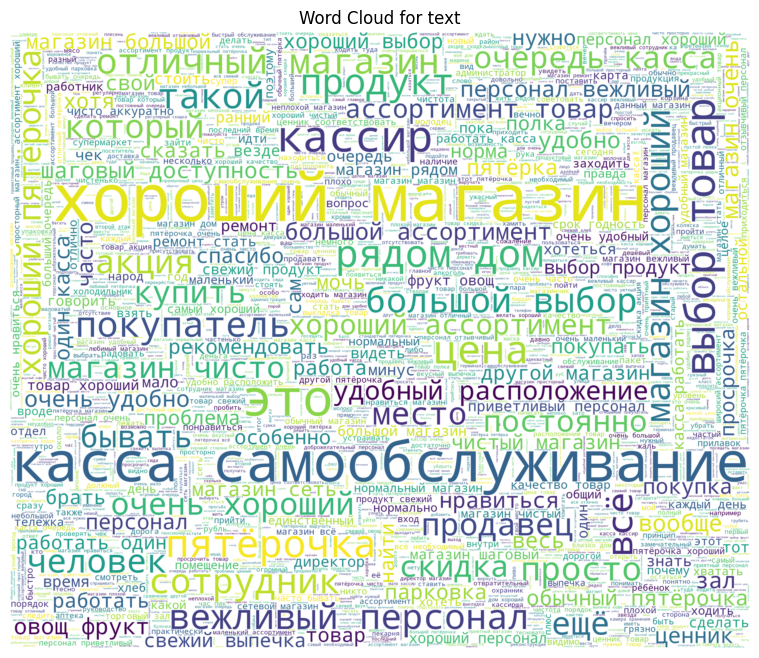

In [13]:
display_word_cloud(df_token, text_column='text')

In [14]:
test_data['text'] = test_data['text'].progress_apply(text_cleaning)

  0%|          | 0/12167 [00:00<?, ?it/s]

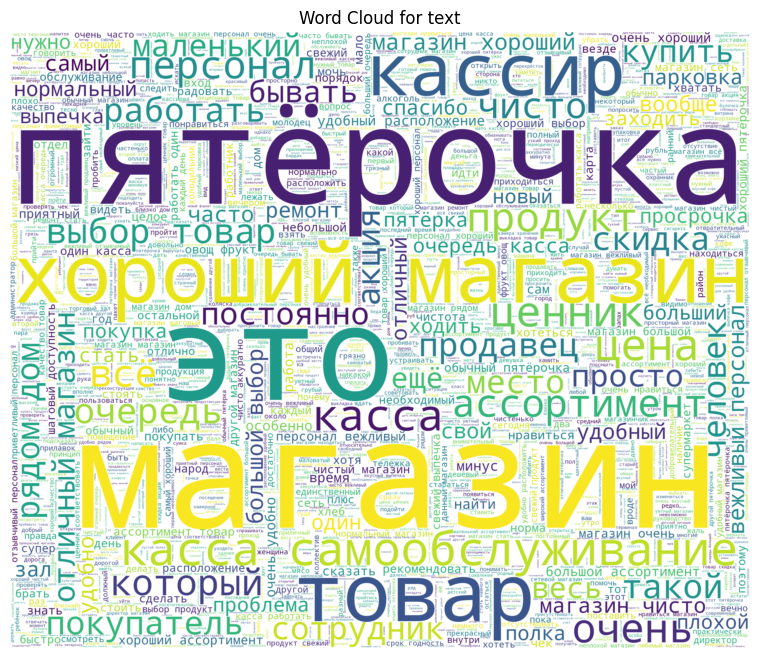

In [15]:
display_word_cloud(test_data, text_column='text')

In [16]:
df_token["num_words"] = df_token["text"].apply(
    lambda x: len(str(x).split()))
test_data["num_words"] = test_data["text"].apply(
    lambda x: len(str(x).split()))

In [17]:
import plotly.express as px
fig = px.histogram(
    df_token,
    x=df_token["num_words"],
    marginal="box",
    title="Number of Words in Train data",
    color_discrete_sequence=["#FFA200"]
)
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(
    family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

In [18]:
fig = px.histogram(
    test_data,
    x=test_data["num_words"],
    marginal="box",
    title="Number of Words in Test data",
    color_discrete_sequence=["#FFA200"]
)
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(
    family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

In [19]:
df_token['num_words'].describe()

count    48665.000000
mean        12.203432
std         13.205423
min          0.000000
25%          5.000000
50%          9.000000
75%         15.000000
max        364.000000
Name: num_words, dtype: float64

<Axes: >

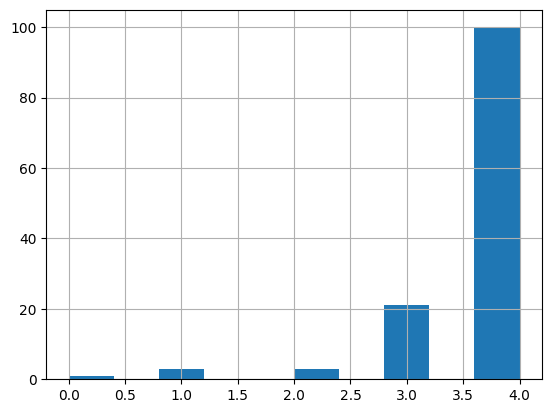

In [20]:
df_token[df_token['num_words'] == 0]['rate'].hist()

In [21]:
len(df_token[df_token['num_words'] > 50])

922

In [22]:
# Удалим просто все образцы с 0 и слишком длинными комментами
df_token = df_token[df_token['num_words'] < 50]
df_token = df_token[df_token['num_words'] != 0]
len(df_token)

47568

In [23]:
fig = px.histogram(df_token, x="num_words", color="rate", title="Number of Words in Train data by group")
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))

fig.show()

# Train Test split

In [24]:
train_split, val_split = train_test_split(df_token, test_size=0.25, random_state=42, shuffle = True, stratify=df_token['rate'])

# Loading tokenizer from pretrained

In [25]:
tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

In [26]:
# Sample of tokenized seq
print(tokenizer(df_token['text'][2]))

{'input_ids': [2, 6003, 66018, 17465, 22390, 36299, 12869, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


# Creating datasets and dataloaders

In [27]:
train_dataset = FiveDataset(train_split, tokenizer, MAX_LEN)
val_dataset = FiveDataset(val_split, tokenizer, MAX_LEN)
test_dataset = FiveDataset(test_data, tokenizer, MAX_LEN)

In [28]:
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)
test_dataloader = DataLoader(test_dataset, **test_params)

# Loading pretrained model from Huggingface

In [29]:
config = {
    "num_classes": 5,
    "dropout_rate": 0.1
}
model = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=config
)

# Creating Trainer object and fitting the model

# Weighting classes

In [30]:
import numpy as np
def compute_class_weight(train_y):
    """
    Compute class weight given imbalanced training data
    Usually used in the neural network model to augment the loss function (weighted loss function)
    Favouring/giving more weights to the rare classes.
    """
    import sklearn.utils.class_weight as scikit_class_weight

    class_list = list(set(train_y))
    class_weight_value = scikit_class_weight.compute_class_weight(class_weight ='balanced', classes = class_list, y = train_y)
    class_weight = dict()

    # Initialize all classes in the dictionary with weight 1
    curr_max = int(np.max(class_list))
    for i in range(curr_max):
        class_weight[i] = 1

    # Build the dictionary using the weight obtained the scikit function
    for i in range(len(class_list)):
        class_weight[class_list[i]] = class_weight_value[i]

    return class_weight

weights = compute_class_weight(df_token['rate'])

In [31]:
import torch

weight_list = []
for key, weight in weights.items():
    weight_list.append(weight)
weight_tensor = torch.FloatTensor(weight_list)
weight_tensor

tensor([2.5567, 4.1346, 1.5987, 0.9735, 0.3684])

In [32]:
trainer_config = {
    "lr": 3e-4,
    "n_epochs": 3,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
    "verbose": 2,
}
t = Trainer(trainer_config, class_weights=weight_tensor)
t.fit(
    model,
    train_dataloader,
    val_dataloader
)

#0.554

Epoch 1/3


  0%|          | 0/991 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



  0%|          | 0/331 [00:00<?, ?it/s]

0.601833164691925
Epoch 2/3


  0%|          | 0/991 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

0.5988059043884277
Epoch 3/3


  0%|          | 0/991 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

0.5451563596725464


ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

# Save model

In [33]:
# t.save("first_model.ckpt")
# t.save("working_model.ckpt")
t.save("w_model_small.ckpt")

# Load pretrained Model

In [34]:
# t = Trainer.load("baseline_model.ckpt")
# t1 = Trainer.load("first_model.ckpt")
# t2 = Trainer.load("second_model.ckpt")
tw = Trainer.load("w_model_small.ckpt")

# Get testset predictions


In [35]:
# predictions = t.predict(test_dataloader)
# predictions1 = t1.predict(test_dataloader)
# predictions2 = t2.predict(test_dataloader)

# Create submission


In [36]:
# sample_submission = pd.read_csv(os.path.join(PATH, "sample_submission.csv"))
# sample_submission["rate"] = predictions2
# sample_submission.rate = le.inverse_transform(sample_submission.rate)
# sample_submission.head()

In [37]:
# sample_submission.to_csv("submission2.csv", index=False)

# Get train predictions for metrics

In [38]:
train_df = FiveDataset(df_token, tokenizer, MAX_LEN)
df_dataloader = DataLoader(train_df, **test_params)

In [39]:
predictions1 = tw.predict(df_dataloader)

Classification Report for tw:
               precision    recall  f1-score   support

           0       0.44      0.81      0.58      2034
           1       0.71      0.30      0.42      5473
           2       0.68      0.35      0.46     11426
           3       0.37      0.48      0.42      7400
           4       0.73      0.89      0.81     21235

    accuracy                           0.63     47568
   macro avg       0.59      0.57      0.54     47568
weighted avg       0.65      0.63      0.61     47568



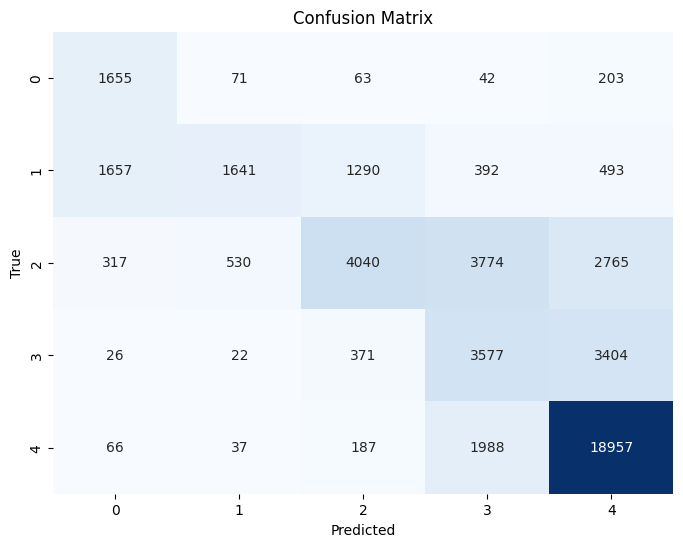

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classification_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# y_true - истинные метки классов
# y_pred - предсказанные метки классов
evaluate_classification_metrics(predictions1, df_token['rate'], "tw")
